<a href="https://colab.research.google.com/github/Caterina1996/SFEW_dataset/blob/master/SFEW_TF_VGG16_dataug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning con VGG16 sin dataugmentation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#Load SFEW data:
!rm -rf SFEW_dataset

!git clone https://github.com/Caterina1996/SFEW_dataset



Cloning into 'SFEW_dataset'...
remote: Enumerating objects: 1333, done.
remote: Counting objects: 100% (1333/1333), done.
remote: Compressing objects: 100% (1321/1321), done.
remote: Total 1333 (delta 14), reused 1324 (delta 12), pack-reused 0
Receiving objects: 100% (1333/1333), 38.54 MiB | 46.65 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
import operator

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications

from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import sklearn.metrics as sk_metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import glob
import ntpath as nt
import os
from PIL import Image
import operator
from keras import optimizers

In [ ]:
# load model without classifier layers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model


In [ ]:
pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.10.12)


In [ ]:
! wandb login f7a6ec99f94602934af48adb60b61fce29736c99

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Init wandb
import wandb
from wandb.keras import WandbCallback
wandb.init(project="FACES_TF")

epoch,124
loss,0.17238
accuracy,0.80863
categorical_accuracy,0.80863
val_loss,0.41098
val_accuracy,0.37376
val_categorical_accuracy,0.37376
_step,257
_runtime,4914
_timestamp,1609442456
best_val_loss,0.37462


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▇▇██▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇█
loss,█▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁█▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄
accuracy,▁▂▃▃▄▄▅▅▅▆▆▇▇▇▇██████▁▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆
categorical_accuracy,▁▂▃▃▄▄▅▅▅▆▆▇▇▇▇██████▁▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆
val_loss,▂▂▁▁▂▁▁▂▂▂▂▃▃▄▄▅▅▆▇▇█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
val_accuracy,▁▅▄▄▃▄▅▆▅▅▆▆▇▆▆▇▅▅▆▅▅▂▃▃▄▆▇▆▇▆█▇█▆▇▇▇▇▇▇
val_categorical_accuracy,▁▅▄▄▃▄▅▆▅▅▆▆▇▆▆▇▅▅▆▅▅▂▃▃▄▆▇▆▇▆█▇█▆▇▇▇▇▇▇
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████


In [ ]:
img_width, img_height =128, 128 #revisar Las originales son 143 x 181
batch_size=2
wandb.config.learning_rate = 0.00001
epochs = 100
wandb.config.batch_size = 2
wandb.config.architecture='VGG16'
wandb.config.img_width, wandb.config.img_height=img_width, img_height
num_classes=7
dropout = 0.25
dataugmentation=True

train_dir='SFEW_dataset/Train'
test_dir='SFEW_dataset/Val'




In [ ]:
def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size):

  if dataugmentation==True:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1
  else:

    train_datagen = ImageDataGenerator(rescale=1. / 255)

  test_datagen= ImageDataGenerator(rescale=1. / 255)

  train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode='grayscale',
    shuffle=True)
  
  test_set = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode='grayscale',
    shuffle=True)
  
  return train_set,test_set

In [ ]:
train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)

nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

train_set.class_indices
emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


In [ ]:
# VGG = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
# VGG.summary()

In [ ]:
# model.summary()

In [ ]:
# #Reentrenaremos solo el último bloque convolucional
# for layer in model.layers[-1:-11]:
#   print(layer.name)


In [ ]:
wandb.config.num_frozen_layers=-11
wandb.config.dataug=False

In [ ]:
def get_emo(prediction):
  emo=list(prediction).index(1)
  return emotions_dict[emo]

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
Sad


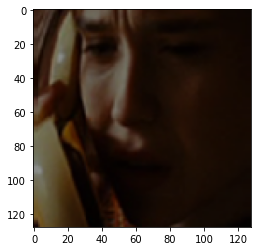

Disgust


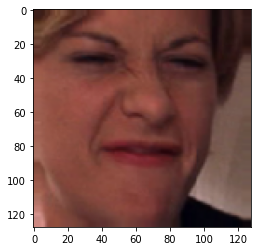

In [ ]:

emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

import tensorflow as tf
x,y = train_set.next()
for i in range(len(x)):
    image = x[i]
    plt.imshow( tf.squeeze(image))
    print(get_emo(y[i]))
    plt.show()

In [ ]:
def create_model(num_frozen_layers,dropout=None):
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  print("VGG_summary:")
  model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[-num_frozen_layers:-4]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model

In [ ]:
def compile_and_train(model,learning_rate,epochs,filepath,batch_size):

  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy','categorical_accuracy'])


  path=filepath+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=50,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)
  WandbCallbacks=WandbCallback(
                monitor='val_loss',
                verbose=1,
                mode='auto',
                generator=test_set,
                validation_steps=nb_test_samples // batch_size,
                input_type="image",
                labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

  callbacks_list = [checkpoint,E_stopping,WandbCallbacks]


  history=model.fit_generator(
          train_set,
          steps_per_epoch=nb_train_samples // batch_size,
          epochs=epochs,
          validation_data=test_set,
          validation_steps=nb_test_samples // batch_size,
          callbacks=callbacks_list)
  
  return history

In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
429/429 [==============================] - 11s 24ms/step - loss: 0.4807 - accuracy: 0.1662 - categorical_accuracy: 0.1662 - val_loss: 0.4083 - val_accuracy: 0.2228 - val_categorical_accuracy: 0.2228

Epoch 00001: val_accuracy improved from -inf to 0.22277, saving model to /content/gdrive/MyDrive/TF_VGG16/Dataugmentation/4/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Dataugmentation/4/assets
Epoch 2/150
429/429 [==============================] - 10s 24ms/step - loss: 0.4151 - accuracy: 0.2165 - categorical_accuracy: 0.2165 - val_loss: 0.4004 - val_accuracy: 0.2376 - val_categorical_accuracy: 0.2376

Epoch 00002: val_accuracy improved from 0.22277 to 0.23762, saving model to /content/gdrive/MyDrive/TF_VGG16/Dataugmentation/4/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Dataugmentation/4/assets
Epoch 3/150
429/429 [==============================] - 10s 23ms/step - loss: 0.4015 - accuracy: 0.2167 - categorical_accuracy: 0.2167 - v

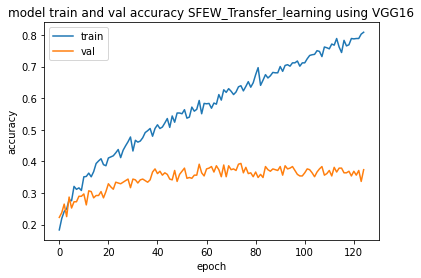

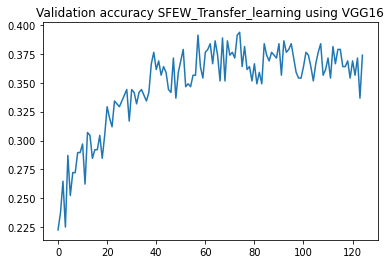

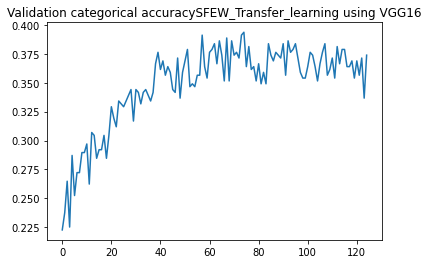

In [ ]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 3 reentrenar 2 bloques convolucionales y dropout 0.5
test_num="4"
dir="/content/gdrive/MyDrive/TF_VGG16/Dataugmentation/"+test_num+"/"

os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=True

model4=create_model(16,0.5)
model4.summary()
len(model4.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

history=compile_and_train(model4,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model4.save(dir+'/SFEW_TF_4.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model4.save("model4.h5")

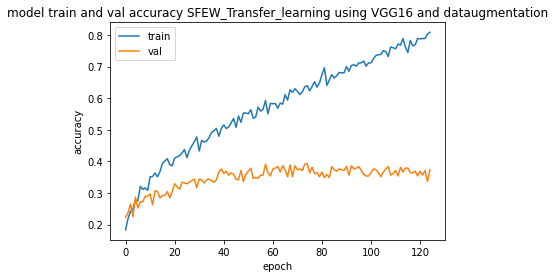

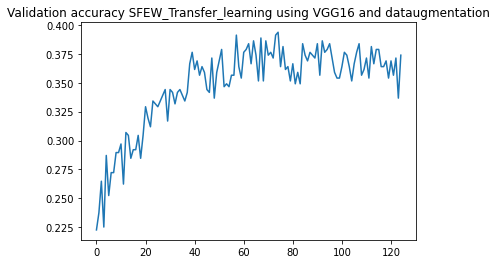

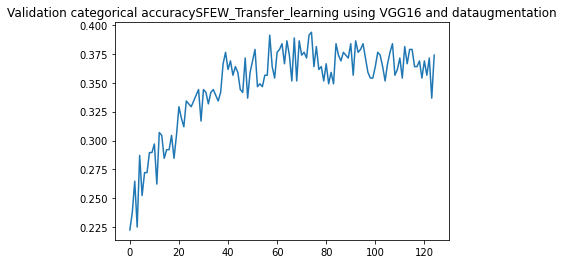

In [ ]:
#Mucho overfitting

model3.save(dir+'/SFEW_TF_dataug_3.h5')
title="SFEW_Transfer_learning using VGG16 and dataugmentation"
plot_model(history,title)
model3.save("model.h5")

In [ ]:
model3.save('gdrive/My Drive/TF_VGG16/Dataug0.h5')

In [79]:
def evaluate_model(model):
  datagen = ImageDataGenerator(rescale=1. / 255)
  test_set = datagen.flow_from_directory(
      'SFEW_dataset/Val',
      target_size=(img_width, img_height),
      batch_size=128,
      class_mode='categorical',
      shuffle=False)

  predictions=model.predict(test_set)
  print('Confusion Matrix')
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(confusion_matrix(test_set.classes, ypred)[:,:])

  for i in range(0,6):
    print("Train: ",list(train_set.class_indices.keys())[i]," ",list(test_set.labels).count(i))
    print("Test: ",list(test_set.class_indices.keys())[i]," ",list(train_set.labels).count(i))

  model.evaluate_generator(test_set)
  print(test_set.class_indices)
  x,y = test_set.next()
  import random
  for i in range(15):
      j=random.randint(1,128)
      image = x[j]
      plt.imshow( tf.squeeze(image),cmap='gray')
      print(get_emo(y[j]))
      print(get_predicted_emo(prediction))
      plt.show()

  return predictions

In [ ]:
prediction=predictions[0]
def get_predicted_emo(prediction):
  emo=list(prediction).index(max(list(prediction)))
  print(prediction)
  return emotions_dict[emo]
  
get_predicted_emo(prediction)
emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

predictions.shape

[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]


(405, 7)

Found 405 images belonging to 7 classes.
Confusion Matrix
[[37  1  1 11 14 11  1]
 [ 7  1  0  1 11  3  0]
 [18  0  3  4 10  8  2]
 [ 4  0  0 37 10  9  2]
 [ 9  0  1  7 54 10  1]
 [11  1  2  6 31 17  0]
 [16  1  2  5 18  5  2]]
76
23
45
62
82
68
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


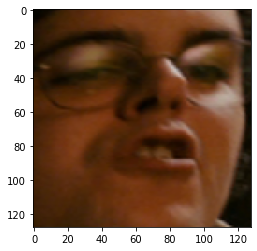

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


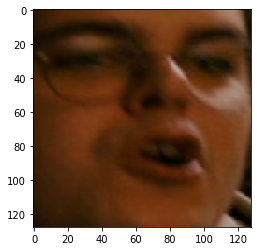

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


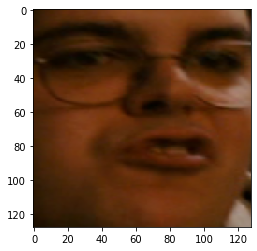

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


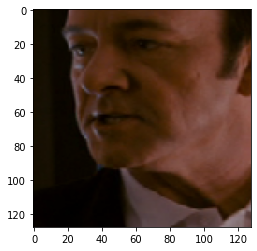

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


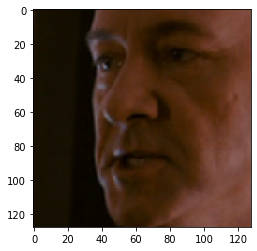

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


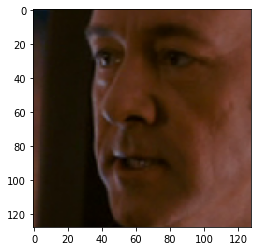

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


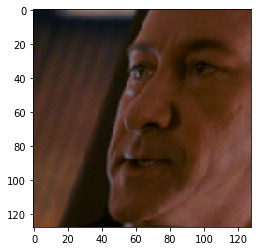

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


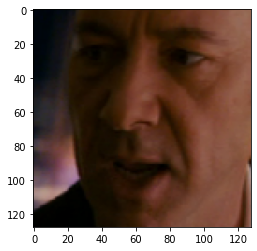

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


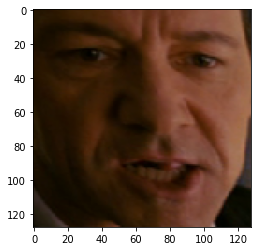

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


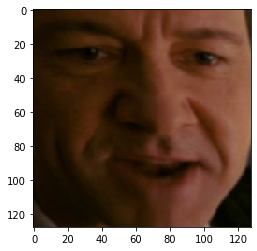

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


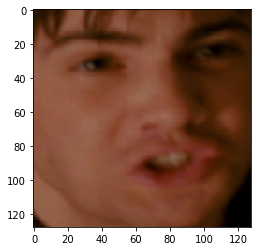

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


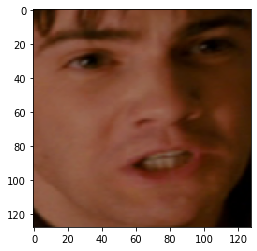

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


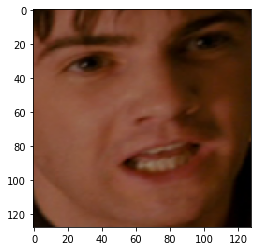

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


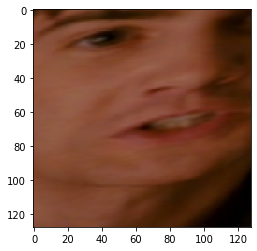

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


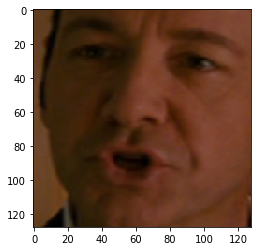

In [76]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=128,
    class_mode='categorical',
    shuffle=False)


predictions=model3.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))


emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

import tensorflow as tf
x,y = test_set.next()
import random
for i in range(15):
    j=random.randint(1,128)
    image = x[i]
    plt.imshow( tf.squeeze(image),cmap='gray')
    print(get_emo(y[i]))
    print(get_predicted_emo(prediction))
    plt.show()

In [ ]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
stop

NameError: ignored

In [69]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size
test_num="5"
dir="/content/gdrive/MyDrive/TF_VGG16/Prueba"+test_num+"/"

os.makedirs(dir)

wandb.config.dropout = 0.5
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=True

model_block2=create_model(16,0.5)
model_block2.summary()
len(model_block2.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
429/429 [==============================] - 11s 23ms/step - loss: 0.5027 - accuracy: 0.1830 - categorical_accuracy: 0.1830 - val_loss: 0.4048 - val_accuracy: 0.1658 - val_categorical_accuracy: 0.1658

Epoch 00001: val_accuracy improved from -inf to 0.16584, saving model to /content/gdrive/MyDrive/TF_VGG16/Prueba5/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Prueba5/assets
Epoch 00000: val_loss improved from inf to 0.40478, saving model to /content/wandb/run-20201231_192105-22nxzilq/files/model-best.h5
Epoch 2/150
429/429 [==============================] - 11s 25ms/step - loss: 0.4141 - accuracy: 0.2279 - categorical_accuracy: 0.2279 - val_loss: 0.4102 - val_accuracy: 0.1856 - val_categorical_accuracy: 0.1856

Epoch 00002: val_accuracy improved from 0.16584 to 0.18564, saving model to /content/gdrive/MyDrive/TF_VGG16/Prueba5/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Prueba5/assets
Epoch 3/150
429/429 [========================

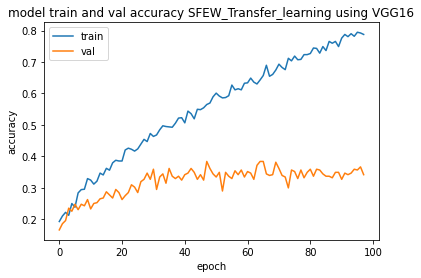

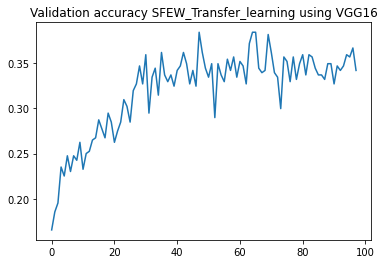

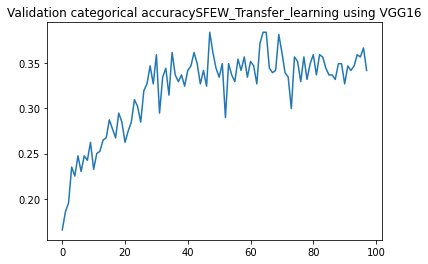

In [70]:


history=compile_and_train(model_block2,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model_block2.save(dir+'/SFEW_TF_2.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model_block2.save("model.h5")

Found 405 images belonging to 7 classes.
Confusion Matrix
[[36  0  2 17 11 10  0]
 [ 5  1  1  3  7  6  0]
 [18  0  5  8  6  8  0]
 [ 8  0  2 40  6  6  0]
 [ 8  0  2  5 57 10  0]
 [11  0 11  9 20 17  0]
 [15  0  6  7 15  6  0]]
Train:  Angry   76
Test:  Angry   172
Train:  Disgust   23
Test:  Disgust   49
Train:  Fear   45
Test:  Fear   76
Train:  Happy   62
Test:  Happy   176
Train:  Neutral   82
Test:  Neutral   142
Train:  Sad   68
Test:  Sad   151


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


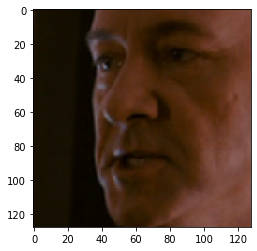

Fear
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


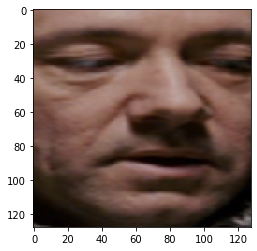

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


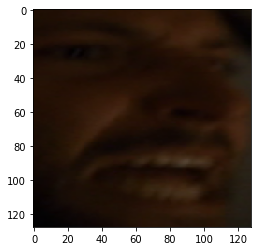

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


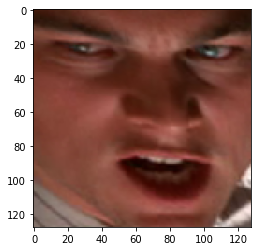

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


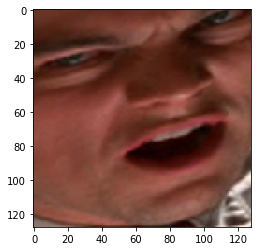

Fear
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


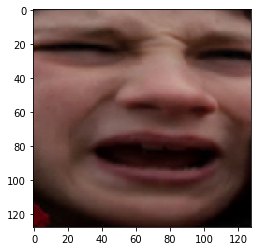

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


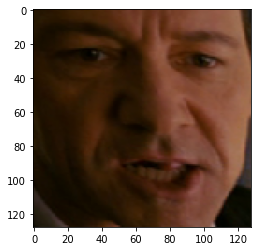

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


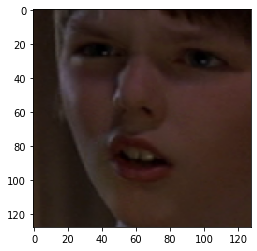

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


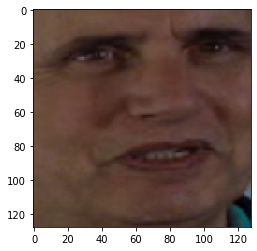

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


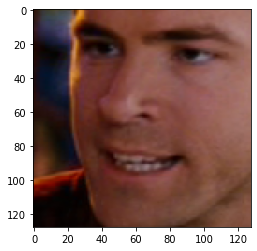

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


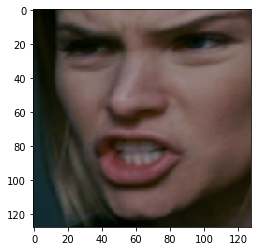

Fear
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


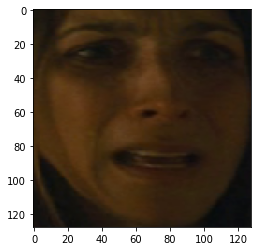

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


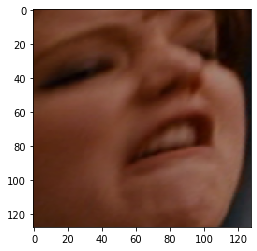

Disgust
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


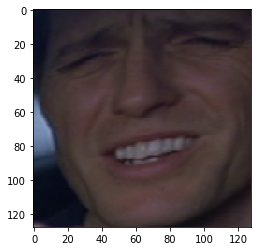

Angry
[9.9179840e-01 7.2341820e-04 1.3929174e-03 1.6273427e-03 1.0933285e-03
 2.7355010e-04 3.0910338e-03]
Angry


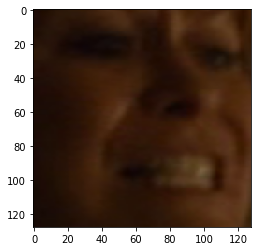

array([[0.9562939 , 0.00773154, 0.00389853, ..., 0.00597925, 0.00754058,
        0.00175872],
       [0.72927815, 0.01976372, 0.01592823, ..., 0.03843646, 0.05649269,
        0.01605225],
       [0.16146256, 0.01992318, 0.08156189, ..., 0.44132343, 0.05640684,
        0.07448549],
       ...,
       [0.1425252 , 0.023684  , 0.09293764, ..., 0.24827242, 0.3294773 ,
        0.04169181],
       [0.16933033, 0.05630473, 0.05579527, ..., 0.12748557, 0.20553197,
        0.03891807],
       [0.11940767, 0.02320638, 0.5251478 , ..., 0.13059464, 0.10759203,
        0.02973365]], dtype=float32)

In [80]:
evaluate_model(model_block2)

In [81]:
model_block2.save(dir+'/SFEW_TF_2.h5')

In [ ]:
stop

In [71]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size
test_num="_2blocs"
dir="/content/gdrive/MyDrive/TF_VGG16/Prueba"+test_num

os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=False

model=create_model(16,0.35)
model.summary()
len(model.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

history=compile_and_train(model,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model.save(dir+'/SFEW_TF_0.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model.save("model.h5")



VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
429/429 [==============================] - 11s 23ms/step - loss: 0.4596 - accuracy: 0.1943 - categorical_accuracy: 0.1943 - val_loss: 0.4002 - val_accuracy: 0.2104 - val_categorical_accuracy: 0.2104

Epoch 00001: val_accuracy improved from -inf to 0.21040, saving model to /content/gdrive/MyDrive/TF_VGG16/Prueba_2blocs
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Prueba_2blocs/assets
Epoch 2/150
429/429 [==============================] - 10s 23ms/step - loss: 0.4058 - accuracy: 0.2192 - categorical_accuracy: 0.2192 - val_loss: 0.4010 - val_accuracy: 0.2822 - val_categorical_accuracy: 0.2822

Epoch 00002: val_accuracy improved from 0.21040 to 0.28218, saving model to /content/gdrive/MyDrive/TF_VGG16/Prueba_2blocs
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TF_VGG16/Prueba_2blocs/assets
Epoch 3/150
429/429 [==============================] - 10s 24ms/step - loss: 0.4030 - accuracy: 0.2278 - categorical_accuracy: 0.2278 - val_loss: 0.4006 - 

KeyboardInterrupt: ignored

In [ ]:
stop

In [ ]:


for layer in model.layers[:-11]:
        layer.trainable = False



# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy','categorical_accuracy'])

filepath="gdrive/My Drive/TFM_MUSI/:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=15,
                                            verbose=1,
                                            mode="auto",
                                            restore_best_weights=True)
WandbCallbacks=WandbCallback(
              monitor='val_loss',
              verbose=1,
              mode='auto',
              generator=test_generator,
              validation_steps=nb_validation_samples // batch_size,
              input_type="image",
              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

callbacks_list = [checkpoint,E_stopping,WandbCallbacks]


history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=callbacks_list)

In [ ]:
model.save('gdrive/My Drive/TFM_MUSI/FacesTF1.h5')

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

predictions=model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))

model.evaluate_generator(test_set)

In [ ]:
prediction=predictions[0]
def get_predicted_emo(prediction):
  emo=list(prediction).index(max(list(prediction)))
  print(prediction)
  return emotions_dict[emo]
get_predicted_emo(prediction)

predictions.shape

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)


predictions=model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))


emotions_dict = {v: k for k, v in train_generator.class_indices.items()}
print(emotions_dict)

import tensorflow as tf

for i in range(15):
    
    image = x[i]
    plt.imshow( tf.squeeze(image),cmap='gray')
    print(get_emo(y[i]))
    print(get_predicted_emo(prediction))
    plt.show()

In [ ]:
model.save('FACESTF1.h5')